In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/Data.zip

In [3]:
class_names =['Bedroom','Coast','Forest','Highway','Industrial','Inside_City','Kitchen','Livingroom','Mountain','Office',
              'Open_Country', 'Store', 'Street', 'Suburb', 'Tall_Building']

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.optim import SGD

In [6]:
def apply_augmentation():
  for name in class_names:
    path = '/content/Data/Train/' + name
    dirListing = os.listdir(path)
    for filename in dirListing:
      im = cv2.imread('/content/Data/Train/' + name + '/'+filename)
      im = cv2.resize(im,(32,32))
      flipped = np.fliplr(im)
      cv2.imwrite('/content/Data/Train/' + name + '/'+ "flipped-"+filename,flipped)


  for name in class_names:
    path = '/content/Data/Test/' + name
    dirListing = os.listdir(path)
    for filename in dirListing:
      im = cv2.imread('/content/Data/Test/' + name + '/'+filename)
      im = cv2.resize(im,(32,32))
      flipped = np.fliplr(im)
      cv2.imwrite('/content/Data/Test/' + name + '/'+ "flipped-"+filename,flipped)

  return

In [7]:
def plot_learned(train_loss, train_acc, test_loss, test_acc, train_top5_list, test_top5_list):

  fig, axs = plt.subplots(1,3)
 
  axs[0].plot(train_loss,color='blue')
  axs[0].plot(test_loss,color='green')
  axs[0].set_title('Loss')
  axs[0].legend(['Train','Test'])


  axs[1].plot(train_acc,color='blue')
  axs[1].plot(test_acc,color='green')
  axs[1].set_title('Accuracy top1')
  axs[1].legend(['Train','Test'])


  axs[2].plot(train_top5_list,color='blue')
  axs[2].plot(test_top5_list,color='green')
  axs[2].set_title('Accuracy top5')
  axs[2].legend(['Train','Test'])


  fig.set_size_inches(30, 8)


  plt.show()

  return

In [8]:
# apply_augmentation()

In [9]:
BATCH_SIZE = 64

# transformations
transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# download and load training dataset
trainset = torchvision.datasets.ImageFolder('/content/Data/Train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder('/content/Data/Test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

In [10]:
def get_accuracy(logit, target, batch_size):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    acc = 100.0 * corrects/batch_size

    return acc.item()

In [11]:
def get_top5(output, target, topk=(1,5)):
    maxk = max(topk)  

    _, pred = torch.topk(input=output, k=5, dim=1, largest=True, sorted=True)
    pred = pred.t()

    target_reshaped = target.view(1, -1).expand_as(pred)  
    correct = (pred == target_reshaped)


    sum1 = torch.sum(correct, 1)
    sum2 = torch.sum(sum1)

    return sum2 *100.0 / BATCH_SIZE

In [12]:
#loading alexnet model
alexnet_model = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


In [13]:
#Model description
# alexnet_model.eval()

In [14]:
#freezing all layers except last one
for param in alexnet_model.parameters():
    param.requires_grad = False
   
#unfreezing last layer
alexnet_model.classifier[6]=nn.Linear(in_features=4096, out_features=15, bias=True)

In [15]:
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
alexnet_model=alexnet_model.to(device)

summary(alexnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [16]:
learning_rate = 0.001
num_epochs = 50

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
alexnet_model=alexnet_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(alexnet_model.parameters(), lr=learning_rate, momentum=0.5)

lmbda = lambda epoch: 0.95
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lmbda)

In [17]:
all_train_loss=[]
all_train_acc=[]

all_test_acc=[]
all_test_loss=[]


train_top5_list=[]
test_top5_list=[]

In [20]:
for epoch in range(num_epochs):

    alexnet_model.train()

    train_running_loss = 0.0
    train_acc = 0.0
    train_top5_acc = 0.0


    # training step
    for i, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)

        logits = alexnet_model(images)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()

        # update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
        train_top5_acc += get_top5(logits, labels)

        
    alexnet_model.eval()

    test_acc = 0.0
    test_running_loss = 0.0
    test_top5_acc =0.0

    
    for j, (images, labels) in enumerate(testloader, 0):
      images = images.to(device)
      labels = labels.to(device)

      outputs = alexnet_model(images)
      loss = criterion(outputs, labels)

      test_running_loss += loss.detach().item()
      test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
      test_top5_acc += get_top5(outputs, labels)


    scheduler.step()

    all_train_loss.append(train_running_loss /i )
    all_train_acc.append(train_acc/i)
    train_top5_list.append(train_top5_acc/(i))

    all_test_loss.append(test_running_loss/j)
    all_test_acc.append(test_acc/j)
    test_top5_list.append(test_top5_acc/j)

    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f | Test Accuracy: %.2f | Test loss: %.4f' \
          %(epoch, train_running_loss / i, train_acc/i, test_acc/j, test_running_loss/j)) 

Epoch: 0 | Loss: 0.3080 | Train Accuracy: 92.22 | Test Accuracy: 88.72 | Test loss: 0.4133
Epoch: 1 | Loss: 0.3072 | Train Accuracy: 91.95 | Test Accuracy: 88.72 | Test loss: 0.4128
Epoch: 2 | Loss: 0.3159 | Train Accuracy: 92.12 | Test Accuracy: 88.72 | Test loss: 0.4119
Epoch: 3 | Loss: 0.3102 | Train Accuracy: 91.64 | Test Accuracy: 88.86 | Test loss: 0.4114
Epoch: 4 | Loss: 0.3040 | Train Accuracy: 91.98 | Test Accuracy: 88.79 | Test loss: 0.4106
Epoch: 5 | Loss: 0.3042 | Train Accuracy: 92.49 | Test Accuracy: 88.99 | Test loss: 0.4104
Epoch: 6 | Loss: 0.3045 | Train Accuracy: 92.02 | Test Accuracy: 88.99 | Test loss: 0.4106
Epoch: 7 | Loss: 0.3066 | Train Accuracy: 92.29 | Test Accuracy: 88.86 | Test loss: 0.4099
Epoch: 8 | Loss: 0.3010 | Train Accuracy: 92.32 | Test Accuracy: 88.79 | Test loss: 0.4097
Epoch: 9 | Loss: 0.3048 | Train Accuracy: 92.63 | Test Accuracy: 88.86 | Test loss: 0.4095


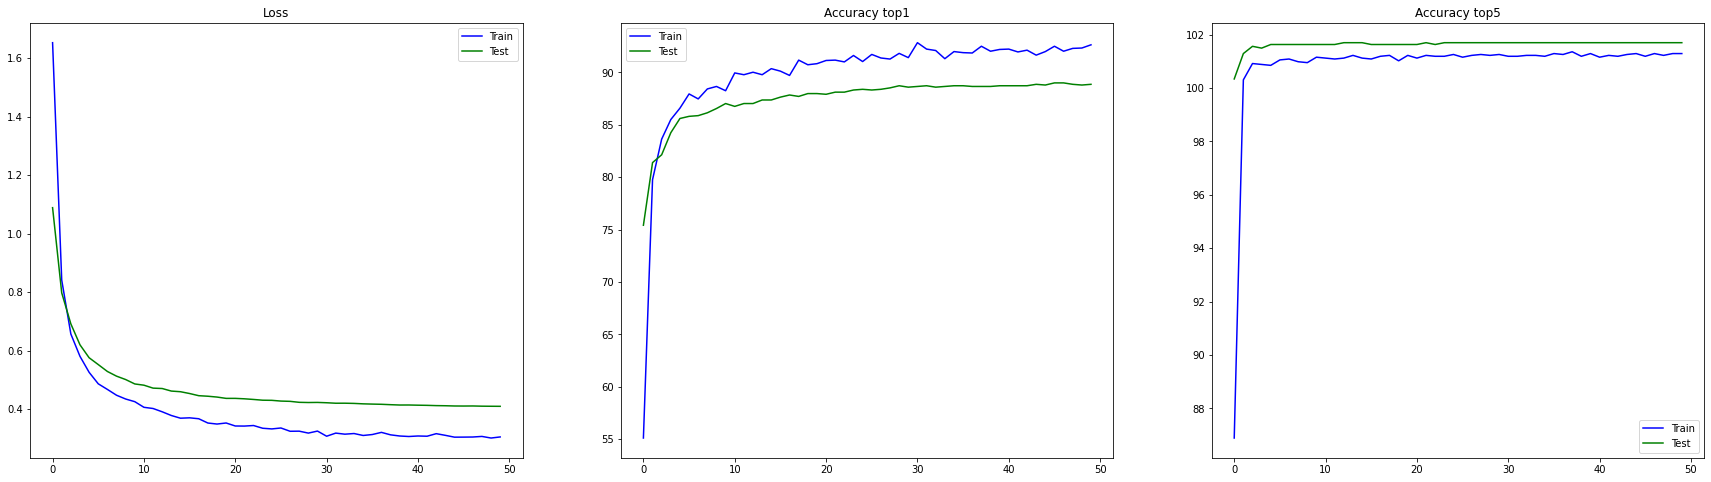

In [21]:
plot_learned(all_train_loss,all_train_acc,all_test_loss,all_test_acc,train_top5_list, test_top5_list)